In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Visualize Dataset

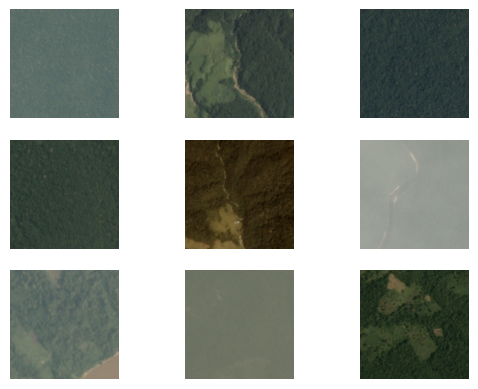

In [2]:
directory = "/kaggle/input/planets-dataset/planet/planet/train-jpg/"
for i in range(9):
    plt.subplot(330 + 1 + i)
    filename = directory + 'train_' + str(i) + '.jpg'
    image = plt.imread(filename)
    plt.imshow(image)
    plt.axis("off")
plt.show()

## Preparing the Dataset

In [3]:
filename = '/kaggle/input/planets-dataset/planet/planet/train_classes.csv'
mapping_csv = pd.read_csv(filename)
print(mapping_csv.shape)
print(mapping_csv[:10])

(40479, 2)
  image_name                                         tags
0    train_0                                 haze primary
1    train_1              agriculture clear primary water
2    train_2                                clear primary
3    train_3                                clear primary
4    train_4    agriculture clear habitation primary road
5    train_5                           haze primary water
6    train_6  agriculture clear cultivation primary water
7    train_7                                 haze primary
8    train_8        agriculture clear cultivation primary
9    train_9   agriculture clear cultivation primary road


In [4]:
labels = set()
for i in range(len(mapping_csv)):
    tags = mapping_csv['tags'][i].split(' ')
    labels.update(tags)
    
labels = list(labels)
labels.sort()

In [5]:
labels

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [6]:
labels_map = {labels[i]:i for i in range(len(labels))}
inv_labels_map = {i:labels[i] for i in range(len(labels))}

In [7]:
labels_map, inv_labels_map

({'agriculture': 0,
  'artisinal_mine': 1,
  'bare_ground': 2,
  'blooming': 3,
  'blow_down': 4,
  'clear': 5,
  'cloudy': 6,
  'conventional_mine': 7,
  'cultivation': 8,
  'habitation': 9,
  'haze': 10,
  'partly_cloudy': 11,
  'primary': 12,
  'road': 13,
  'selective_logging': 14,
  'slash_burn': 15,
  'water': 16},
 {0: 'agriculture',
  1: 'artisinal_mine',
  2: 'bare_ground',
  3: 'blooming',
  4: 'blow_down',
  5: 'clear',
  6: 'cloudy',
  7: 'conventional_mine',
  8: 'cultivation',
  9: 'habitation',
  10: 'haze',
  11: 'partly_cloudy',
  12: 'primary',
  13: 'road',
  14: 'selective_logging',
  15: 'slash_burn',
  16: 'water'})

In [8]:
def create_file_mapping(mapping_csv):
    mapping = dict()
    for i in range(len(mapping_csv)):
        name, tags = mapping_csv['image_name'][i], mapping_csv['tags'][i]
        mapping[name] = tags.split(' ')
    return mapping

file_mapping = create_file_mapping(mapping_csv)
for i, (k, v) in enumerate(file_mapping.items()):
    print(k, v)
    if i >= 15:
        break

train_0 ['haze', 'primary']
train_1 ['agriculture', 'clear', 'primary', 'water']
train_2 ['clear', 'primary']
train_3 ['clear', 'primary']
train_4 ['agriculture', 'clear', 'habitation', 'primary', 'road']
train_5 ['haze', 'primary', 'water']
train_6 ['agriculture', 'clear', 'cultivation', 'primary', 'water']
train_7 ['haze', 'primary']
train_8 ['agriculture', 'clear', 'cultivation', 'primary']
train_9 ['agriculture', 'clear', 'cultivation', 'primary', 'road']
train_10 ['agriculture', 'clear', 'primary', 'slash_burn', 'water']
train_11 ['clear', 'primary', 'water']
train_12 ['cloudy']
train_13 ['clear', 'primary']
train_14 ['cloudy']
train_15 ['clear', 'primary']


In [9]:
# Create a One-hot encoding for one list of tags
def one_hot_encode(tags, mapping):
    encoding = np.zeros(len(mapping), dtype='uint8')
    for tag in tags:
        encoding[mapping[tag]] = 1
    return encoding

In [10]:
# Load all the images into memory
def load_dataset(path, file_mapping):
    photos, targets = list(), list()
    for filename in os.listdir(directory):
        photo = keras.utils.load_img(path + filename, target_size=(32, 32))
        photo = keras.utils.img_to_array(photo, dtype='uint8')
        tags = file_mapping[filename[:-4]]
        target = one_hot_encode(tags, labels_map)
        photos.append(photo)
        targets.append(target)
    X = np.asarray(photos, dtype='uint8')
    y = np.asarray(targets, dtype='uint8')
    return X, y

In [11]:
filename = '/kaggle/input/planets-dataset/planet/planet/train_classes.csv'
mapping_csv = pd.read_csv(filename)
file_mapping = create_file_mapping(mapping_csv)
directory = '/kaggle/input/planets-dataset/planet/planet/train-jpg/'
x, y = load_dataset(directory, file_mapping)
print(x.shape, y.shape)
np.savez_compressed('planet.npz', x, y)

(40479, 32, 32, 3) (40479, 17)


## Decompressing the Dataset

In [12]:
def decompress_dataset():
    data = np.load('planet.npz')
    x, y = data['arr_0'], data['arr_1']
    # Split the dataset
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    return x_train, y_train, x_test, y_test

In [13]:
x_train, y_train, x_test, y_test = decompress_dataset()
y_train[0]

(28335, 32, 32, 3) (28335, 17) (12144, 32, 32, 3) (12144, 17)


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8)

## Evaluation Metrics

$precision = \frac{true \; positives}{true \; positives \; + \; false \; positives} $

$recall = \frac{true \; positives}{true \; positives \; + \; false \; negatives} $

$F1 = 2 \; x \; \frac{true \; positives}{true \; positives \; + \; false \; negatives} $

$F-beta = (1 \; + \; beta^2) \; x \; \frac{true \; positives}{true \; positives \; + \; false \; negatives} $

In [14]:
def fbeta(y_true, y_pred, beta=2):
    y_pred = keras.backend.clip(y_pred, 0, 1)
    tp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true - y_pred, 0, 1)), axis=1)
    precision = tp / (tp + fp + keras.backend.epsilon())
    recall = tp / (tp + fn + keras.backend.epsilon())
    f_beta_score = keras.backend.mean((1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + keras.backend.epsilon()))
    return f_beta_score

## Deep Convolutional Model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                             

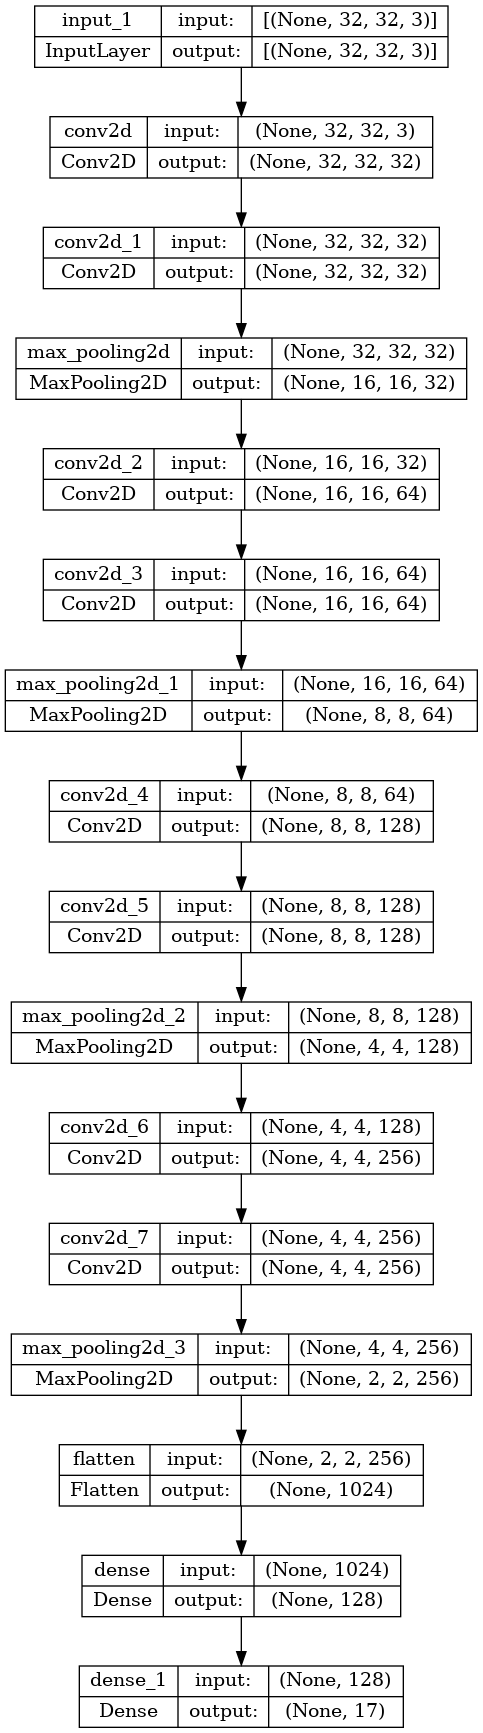

In [15]:
# Frame the model
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_initializer="he_uniform", padding="same")(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_initializer="he_uniform", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", kernel_initializer="he_uniform", padding="same")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", kernel_initializer="he_uniform", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", kernel_initializer="he_uniform", padding="same")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", kernel_initializer="he_uniform", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", kernel_initializer="he_uniform", padding="same")(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", kernel_initializer="he_uniform", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu", kernel_initializer="he_uniform")(x)
outputs = layers.Dense(17, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [16]:
# Compile the model
model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics=[fbeta])

In [17]:
def plot_evaluation(history):
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    
    plt.subplot(212)
    plt.title('Fbeta')
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='test')
    
    plt.legend()
    plt.show()
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png')
    plt.close()

In [18]:
# Train the model
x_train, y_train, x_test, y_test = decompress_dataset()
# Rescaling and augmenting the images
train_image_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True,
                                                                   vertical_flip=True, rotation_range=90)
test_image_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
train_data = train_image_data_generator.flow(x_train, y_train, batch_size=128)
test_data = test_image_data_generator.flow(x_test, y_test, batch_size=128)
history = model.fit(train_data, 
                    validation_data=test_data,
                    epochs=50)

(28335, 32, 32, 3) (28335, 17) (12144, 32, 32, 3) (12144, 17)
Epoch 1/50
222/222 [==============================] - 34s 94ms/step - loss: 0.2092 - fbeta: 0.7023 - val_loss: 0.1765 - val_fbeta: 0.7585
Epoch 2/50
222/222 [==============================] - 20s 88ms/step - loss: 0.1632 - fbeta: 0.7831 - val_loss: 0.1519 - val_fbeta: 0.8137
Epoch 3/50
222/222 [==============================] - 20s 91ms/step - loss: 0.1509 - fbeta: 0.8041 - val_loss: 0.1572 - val_fbeta: 0.7999
Epoch 4/50
222/222 [==============================] - 20s 91ms/step - loss: 0.1471 - fbeta: 0.8096 - val_loss: 0.1465 - val_fbeta: 0.8245
Epoch 5/50
222/222 [==============================] - 20s 89ms/step - loss: 0.1406 - fbeta: 0.8199 - val_loss: 0.1360 - val_fbeta: 0.8273
Epoch 6/50
222/222 [==============================] - 20s 92ms/step - loss: 0.1373 - fbeta: 0.8255 - val_loss: 0.1552 - val_fbeta: 0.8063
Epoch 7/50
222/222 [==============================] - 20s 88ms/step - loss: 0.1343 - fbeta: 0.8298 - val_loss:

In [19]:
loss, fbeta = model.evaluate(test_data)
print(f'Loss: {loss:.3f}, Fbeta: {fbeta:.3f}')

95/95 [==============================] - 2s 15ms/step - loss: 0.1215 - fbeta: 0.8667
Loss: 0.121, Fbeta: 0.867


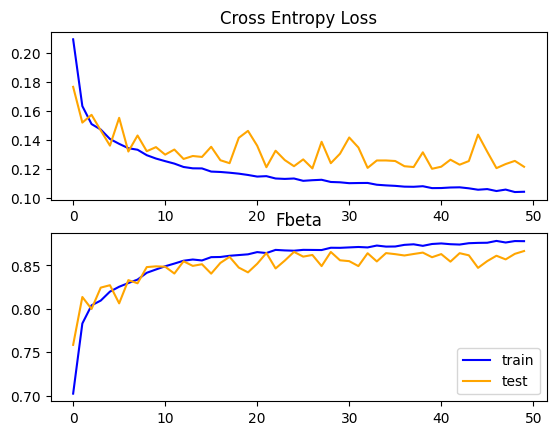

In [20]:
plot_evaluation(history)

## Final Predictions

In [33]:
def prediction_to_tags(inv_mapping, prediction):
    values = prediction.round()
    tags = [inv_mapping[i] for i in range(len(values)) if values[i] == 1.0]
    return tags

In [34]:
def load_image(filename):
    img = keras.utils.load_img(filename, target_size=(32, 32))
    img = keras.utils.img_to_array(img)
    img = img.reshape(1, 32, 32, 3)
    img = img.astype('float32')
    return img

In [35]:
def display_predictions(filename):
    directory_name = '/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/'
    img = load_image(directory_name + filename)
    result = model.predict(img)
    tags = prediction_to_tags(inv_labels_map, result[0])
    image = plt.imread(directory_name + filename)
    plt.imshow(image)
    plt.axis("off")
    plt.title(tags)

1/1 [==============================] - 0s 23ms/step


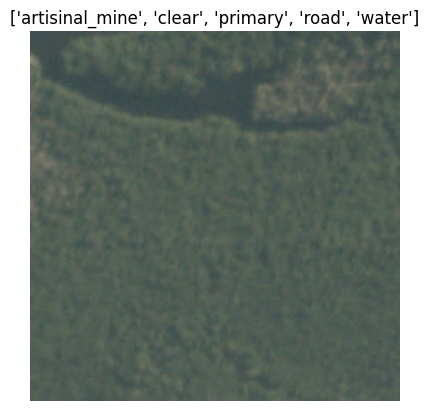

In [36]:
display_predictions('file_100.jpg')

1/1 [==============================] - 0s 50ms/step


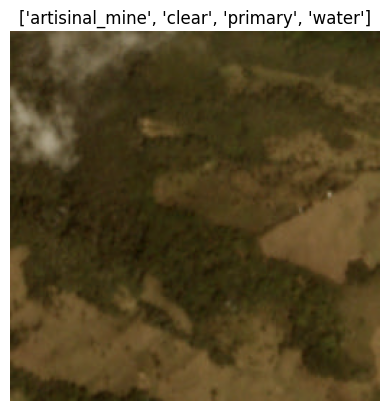

In [37]:
display_predictions('file_1.jpg')

1/1 [==============================] - 0s 23ms/step


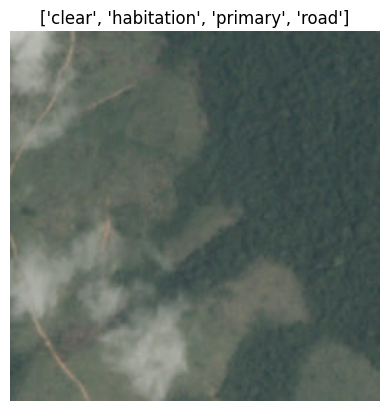

In [38]:
display_predictions('file_4.jpg')